Mon Nov 11 13:46:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+

## Credit:

This notebook is based on a following tutorial on the https://curiousily.com website: https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p

import scipy
from scipy import io
import os
from pathlib import Path

import source.data_load_transform as dlt

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Verifica se 'mps' è disponibile su Apple Silicon

device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

 

# Conferma del dispositivo selezionato

print("Using device:", device)

Using device: mps




In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

    Read the tutorial
    Run the notebook in your browser (Google Colab)
    Read the Getting Things Done with Pytorch book

By the end of this tutorial, you'll learn how to:

    Prepare a dataset for Anomaly Detection from Time Series Data
    Build an LSTM Autoencoder with PyTorch
    Train and evaluate your model
    Choose a threshold for anomaly detection
    Classify unseen examples as normal or anomaly



### Data

The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

    An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

    Normal (N)
    R-on-T Premature Ventricular Contraction (R-on-T PVC)
    Premature Ventricular Contraction (PVC)
    Supra-ventricular Premature or Ectopic Beat (SP or EB)
    Unclassified Beat (UB).

    Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans) Source

The dataset is available on my Google Drive. Let's get it:

In [3]:
os.listdir()

['.DS_Store',
 'requirements.txt',
 'source',
 '.gitignore',
 'autoencoder_first_try.ipynb',
 '.ipynb_checkpoints',
 '.git',
 'autoencoder_tutorial.ipynb',
 'data']

In [4]:
os.getcwd()

'/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch/project'

## Load Data and Sound Meta-Data:

### Define file_paths: 

In [5]:
root_path = Path('/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch/project')
path_to_data = root_path/'data/MICRO_Motion_Capture/movement_data'
path_to_sound_meta_data = root_path/'data/MICRO_Motion_Capture/sound_data'

In [6]:
os.chdir(root_path)

In [7]:
os.chdir(path_to_data)

In [8]:
os.listdir()

['NM0001.tsv',
 'NM0002.tsv',
 'NM0003.tsv',
 'NM0007.tsv',
 'NM0012.tsv',
 'NM0006.tsv',
 'NM0010.tsv',
 'NM0004.tsv',
 'NM0005.tsv',
 'NM0011.tsv',
 'NM0008.tsv',
 'NM0009.tsv']

Get a list of all data files:

In [9]:
nm_files = os.listdir()
nm_files.sort()
nm_files

['NM0001.tsv',
 'NM0002.tsv',
 'NM0003.tsv',
 'NM0004.tsv',
 'NM0005.tsv',
 'NM0006.tsv',
 'NM0007.tsv',
 'NM0008.tsv',
 'NM0009.tsv',
 'NM0010.tsv',
 'NM0011.tsv',
 'NM0012.tsv']

In [10]:
#nm12raw = pd.read_csv('NM0012.tsv', delimiter='\t', encoding='utf-8', skiprows=10, low_memory=False)
#nm12raw.drop(nm12raw.columns[len(nm12raw.columns)-1], axis=1, inplace=True)

### Load all data into a dictionary (each entry is the data from one group of study participants:

In [11]:
nm_data_raw = {}

i=1

for filename in nm_files:
    print(filename)
    nm_data_raw[i] = pd.read_csv(filename, delimiter='\t', encoding='utf-8', skiprows=10, low_memory=False)
    nm_data_raw[i].drop(nm_data_raw[i].columns[len(nm_data_raw[i].columns)-1], axis=1, inplace=True)
    i = i+1

NM0001.tsv
NM0002.tsv
NM0003.tsv
NM0004.tsv
NM0005.tsv
NM0006.tsv
NM0007.tsv
NM0008.tsv
NM0009.tsv
NM0010.tsv
NM0011.tsv
NM0012.tsv


### Have a look:

In [12]:
nm_data_raw.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [13]:
nm_data_raw[2].head()

,S2 X,S2 Y,S2 Z,S5 X,S5 Y,S5 Z,S6 X,S6 Y,S6 Z,S8 X,...,S12 Z,Corner1 X,Corner1 Y,Corner1 Z,Corner2 X,Corner2 Y,Corner2 Z,Corner3 X,Corner3 Y,Corner3 Z
0,-155.178,947.129,1876.783,-1101.584,163.179,1788.721,-163.050,137.777,1650.985,1441.440,...,1786.817,-1563.902,1551.982,1880.539,2165.307,1504.473,1859.317,2078.214,-1197.849,1874.806
1,-155.142,947.188,1876.791,-1101.592,163.268,1788.697,-163.045,137.846,1650.974,1441.220,...,1786.818,-1563.883,1551.958,1880.532,2165.418,1504.507,1859.353,2078.206,-1197.832,1874.801
2,-155.097,947.247,1876.817,-1101.606,163.376,1788.692,-163.032,137.934,1650.971,1441.215,...,1786.628,-1563.892,1551.960,1880.528,2165.418,1504.507,1859.353,2078.182,-1197.823,1874.771
3,-155.033,947.247,1876.843,-1101.561,163.401,1788.626,-162.996,138.018,1650.963,1441.301,...,1786.544,-1563.909,1551.990,1880.544,2165.529,1504.451,1859.399,2078.138,-1197.883,1874.840
4,-155.016,947.301,1876.841,-1101.584,163.514,1788.640,-162.980,138.112,1650.945,1441.296,...,1786.610,-1563.906,1551.985,1880.548,2165.446,1504.441,1859.359,2078.127,-1197.890,1874.852


In [14]:
nm_data_raw[1].shape

(36000, 48)

In [15]:
nm_data_raw[1].columns

Index(['S1 X', 'S1 Y', 'S1 Z', 'S2 X', 'S2 Y', 'S2 Z', 'S3 X', 'S3 Y', 'S3 Z',
       'S4 X', 'S4 Y', 'S4 Z', 'S5 X', 'S5 Y', 'S5 Z', 'S6 X', 'S6 Y', 'S6 Z',
       'S7 X', 'S7 Y', 'S7 Z', 'S8 X', 'S8 Y', 'S8 Z', 'S9 X', 'S9 Y', 'S9 Z',
       'S10 X', 'S10 Y', 'S10 Z', 'S11 X', 'S11 Y', 'S11 Z', 'S12 X', 'S12 Y',
       'S12 Z', 'Corner1 X', 'Corner1 Y', 'Corner1 Z', 'Corner2 X',
       'Corner2 Y', 'Corner2 Z', 'Corner3 X', 'Corner3 Y', 'Corner3 Z',
       'Corner4 X', 'Corner4 Y', 'Corner4 Z'],
      dtype='object')

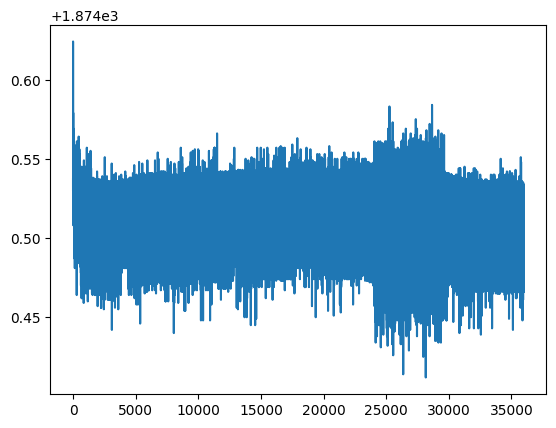

In [16]:
plt.plot(nm_data_raw[1]['Corner3 Z'])

### Load sound meta-data (order of songs for each group of study participants:

In [17]:
os.chdir(path_to_sound_meta_data)

In [18]:
song_order = pd.read_csv('nm15_song_order.csv')
song_order

,1,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


In [19]:
song_order.shape

(12, 5)

In [20]:
song_order.columns = ['groups', 2, 3, 4, 5]
song_order

,groups,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


In [21]:
song_order

,groups,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


Add a column of 1 (silence sound track) at the beginning and at the end of the data frame because each experiment started and ended with one minute of silence:

In [22]:
first_minute = [int(1)]*song_order.shape[0]
last_minute = [int(1)]*song_order.shape[0]

In [23]:
song_order.insert(1, 1, first_minute)
song_order.insert(song_order.shape[1], 6, last_minute)
song_order

,groups,1,2,3,4,5,6
0,A,1,3,1,2,4,1
1,B,1,1,2,4,3,1
2,C,1,1,2,3,4,1
3,D,1,2,3,4,1,1
4,E,1,1,2,3,4,1
5,F,1,3,1,2,4,1
6,G,1,3,2,4,1,1
7,H,1,3,2,4,1,1
8,I,1,3,1,2,4,1
9,J,1,3,4,2,1,1


Replace the letters that designate the experimental groups with numbers:

In [24]:
song_order.groups = list(range(1,13))
song_order

,groups,1,2,3,4,5,6
0,1,1,3,1,2,4,1
1,2,1,1,2,4,3,1
2,3,1,1,2,3,4,1
3,4,1,2,3,4,1,1
4,5,1,1,2,3,4,1
5,6,1,3,1,2,4,1
6,7,1,3,2,4,1,1
7,8,1,3,2,4,1,1
8,9,1,3,1,2,4,1
9,10,1,3,4,2,1,1


### Attribute sound track number to the time series data:

In [25]:
nm_data_labelled = dlt.attribute_sound_track_labels(song_order, nm_data_raw)

In [26]:
nm_data_labelled[1].head()

,S1 X,S1 Y,S1 Z,S2 X,S2 Y,S2 Z,S3 X,S3 Y,S3 Z,S4 X,...,Corner2 X,Corner2 Y,Corner2 Z,Corner3 X,Corner3 Y,Corner3 Z,Corner4 X,Corner4 Y,Corner4 Z,target
0,-1132.908,1053.272,1738.612,-577.677,983.700,1680.741,319.148,1002.059,1793.367,1323.212,...,2164.907,1504.309,1859.115,2079.816,-1237.564,1874.537,-1678.877,-1008.469,1870.884,1
1,-1132.979,1053.367,1738.614,-577.466,983.874,1680.804,319.131,1001.943,1793.363,1321.374,...,2164.909,1504.296,1859.115,2079.834,-1237.573,1874.530,-1678.953,-1008.503,1870.912,1
2,-1133.041,1053.458,1738.627,-577.294,984.055,1680.878,319.120,1001.800,1793.369,1321.383,...,2164.942,1504.317,1859.114,2079.857,-1237.581,1874.560,-1678.953,-1008.503,1870.912,1
3,-1133.070,1053.473,1738.604,-577.121,984.249,1680.953,319.087,1001.616,1793.341,1321.124,...,2164.932,1504.229,1859.118,2079.720,-1237.606,1874.586,-1678.955,-1008.444,1870.999,1
4,-1133.117,1053.564,1738.602,-576.947,984.451,1680.971,319.006,1001.445,1793.341,1321.112,...,2164.930,1504.208,1859.116,2079.818,-1237.633,1874.624,-1678.955,-1008.444,1870.999,1


## Take all data from sound track silence and put them into one data frame:

In [27]:
CLASS_NORMAL = 2

In [28]:
type(nm_data_labelled)

dict

In [29]:
nm_data_1 = nm_data_labelled[1].copy()

In [30]:
nm_data_try = {'1': nm_data_1}

In [31]:
type(nm_data_try)

dict

In [32]:

#normal_data_all_1d = take_data_with_label_or_not(nm_data_labelled, CLASS_NORMAL)

normal_data_all_1d = dlt.take_data_with_label_or_not(nm_data_try, CLASS_NORMAL)

(6000, 17)


In [33]:
normal_data_all_1d.head()

,S1 X,S2 X,S3 X,S4 X,S5 X,S6 X,S7 X,S8 X,S9 X,S10 X,S11 X,S12 X,Corner1 X,Corner2 X,Corner3 X,Corner4 X,target
18000,-1149.069,-582.429,325.406,1311.342,-1189.094,-322.937,558.231,1295.362,-1268.207,-334.865,518.990,1345.527,-1563.818,2164.929,2079.774,-1678.990,2
18001,-1149.100,-582.270,325.514,1311.326,-1189.138,-322.905,558.272,1295.318,-1268.287,-334.877,519.005,1345.553,-1563.824,2164.929,2079.832,-1679.013,2
18002,-1149.124,-582.128,325.604,1311.364,-1189.171,-322.887,558.324,1295.267,-1268.304,-334.884,519.042,1345.634,-1563.824,2164.936,2079.765,-1678.954,2
18003,-1149.157,-581.991,325.702,1311.409,-1189.197,-322.863,558.379,1295.229,-1268.383,-334.939,519.062,1345.659,-1563.824,2164.932,2079.814,-1678.966,2
18004,-1149.210,-581.866,325.802,1311.461,-1189.207,-322.831,558.443,1295.228,-1268.459,-334.972,519.073,1345.664,-1563.824,2164.936,2079.756,-1678.977,2


In [34]:
set(normal_data_all_1d.target)

{2}

In [35]:
normal_data_all_1d.reset_index(inplace=True, drop=True)

Transpose the data frame by sound track length (each batch of data corresponding to one sound track has to be transposed individually because one row should contain the time series corresponding to one sound track:

In [36]:
normal_data_all_1d_t = dlt.transpose_by_minute(normal_data_all_1d)
normal_data_all_1d_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
S1 X,-1149.069,-1149.100,-1149.124,-1149.157,-1149.210,-1149.282,-1149.324,-1149.390,-1149.352,-1149.407,...,-1150.497,-1150.582,-1150.683,-1150.785,-1150.869,-1150.961,-1151.071,-1151.167,-1151.242,-1151.331
S2 X,-582.429,-582.270,-582.128,-581.991,-581.866,-581.746,-581.652,-581.564,-581.510,-581.470,...,-586.810,-586.702,-586.629,-586.532,-586.473,-586.411,-586.353,-586.275,-586.205,-586.128
S3 X,325.406,325.514,325.604,325.702,325.802,325.894,325.948,326.070,326.155,326.234,...,323.917,323.809,323.727,323.630,323.570,323.498,323.447,323.376,323.339,323.269
S4 X,1311.342,1311.326,1311.364,1311.409,1311.461,1311.524,1311.509,1311.586,1311.614,1311.602,...,1312.472,1312.438,1312.421,1312.396,1312.373,1312.331,1312.288,1312.266,1312.193,1312.142
S5 X,-1189.094,-1189.138,-1189.171,-1189.197,-1189.207,-1189.209,-1189.238,-1189.248,-1189.282,-1189.314,...,-1182.030,-1182.021,-1182.029,-1182.053,-1182.076,-1182.125,-1182.154,-1182.202,-1182.250,-1182.310


In [37]:
normal_data_all_1d_t.shape

(16, 6000)

In [38]:
normal_data_all_1d_t = normal_data_all_1d_t.iloc[:,0:600].copy()

In [39]:
normal_data_all_1d_t.shape

(16, 600)

## Take all data from music sound tracks and put them into one data frame:

In [40]:

anomaly_data_all_1d = dlt.take_data_with_label_or_not(nm_data_try, CLASS_NORMAL, with_label=False)

#anomaly_data_all_1d = take_data_with_label_or_not(nm_data_labelled, CLASS_NORMAL, with_label=False)

(30000, 17)


In [41]:
anomaly_data_all_1d.head()

,S1 X,S2 X,S3 X,S4 X,S5 X,S6 X,S7 X,S8 X,S9 X,S10 X,S11 X,S12 X,Corner1 X,Corner2 X,Corner3 X,Corner4 X,target
0,-1132.908,-577.677,319.148,1323.212,-1184.425,-327.140,522.711,1334.210,-1283.543,-313.999,518.993,1350.808,-1563.808,2164.907,2079.816,-1678.877,1
1,-1132.979,-577.466,319.131,1321.374,-1184.403,-326.955,522.756,1334.231,-1283.653,-314.005,519.038,1350.901,-1563.821,2164.909,2079.834,-1678.953,1
2,-1133.041,-577.294,319.120,1321.383,-1184.367,-326.757,522.773,1334.269,-1283.615,-314.042,519.087,1350.980,-1563.805,2164.942,2079.857,-1678.953,1
3,-1133.070,-577.121,319.087,1321.124,-1184.307,-326.536,522.807,1334.260,-1283.641,-314.076,519.123,1350.993,-1563.805,2164.932,2079.720,-1678.955,1
4,-1133.117,-576.947,319.006,1321.112,-1184.249,-326.348,522.831,1334.267,-1283.600,-314.057,519.165,1351.058,-1563.805,2164.930,2079.818,-1678.955,1


In [42]:
set(anomaly_data_all_1d.target)

{1, 3, 4}

In [43]:
anomaly_data_all_1d.reset_index(inplace=True, drop=True)

In [44]:
anomaly_data_all_1d_t = dlt.transpose_by_minute(anomaly_data_all_1d)
anomaly_data_all_1d_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
S1 X,-1132.908,-1132.979,-1133.041,-1133.070,-1133.117,-1133.110,-1133.115,-1133.159,-1133.185,-1133.216,...,-1134.592,-1134.635,-1134.727,-1134.805,-1134.750,-1134.856,-1135.040,-1135.126,-1135.225,-1135.317
S2 X,-577.677,-577.466,-577.294,-577.121,-576.947,-576.829,-576.828,-576.588,-576.494,-576.402,...,-581.431,-581.390,-581.369,-581.332,-581.302,-581.301,-581.279,-581.257,-581.229,-581.209
S3 X,319.148,319.131,319.120,319.087,319.006,318.800,318.751,318.674,318.550,318.401,...,337.239,337.249,337.285,337.288,337.322,337.337,337.329,337.352,337.352,337.349
S4 X,1323.212,1321.374,1321.383,1321.124,1321.112,1321.037,1321.344,1320.960,1320.915,1320.860,...,1312.025,1312.038,1312.052,1312.065,1312.058,1312.050,1312.061,1312.082,1312.071,1312.074
S5 X,-1184.425,-1184.403,-1184.367,-1184.307,-1184.249,-1184.142,-1184.196,-1184.157,-1184.111,-1184.065,...,-1182.241,-1182.208,-1182.184,-1182.161,-1182.127,-1182.110,-1182.094,-1182.065,-1182.046,-1182.023


In [45]:
anomaly_data_all_1d_t = anomaly_data_all_1d_t.iloc[:,0:600].copy()

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [46]:
normal_data_all_1d.target.value_counts()

target
2    6000
Name: count, dtype: int64

target_list = []
for index, row in normal_data_all_1d.iterrows():
    #target_as_string = row.target.decode("utf-8")
    #print(target_as_string)
    #print(int(target_as_string))
    target_list.append(int(target_as_string))

df.target = target_list

In [47]:
normal_data_all_1d.head()

,S1 X,S2 X,S3 X,S4 X,S5 X,S6 X,S7 X,S8 X,S9 X,S10 X,S11 X,S12 X,Corner1 X,Corner2 X,Corner3 X,Corner4 X,target
0,-1149.069,-582.429,325.406,1311.342,-1189.094,-322.937,558.231,1295.362,-1268.207,-334.865,518.990,1345.527,-1563.818,2164.929,2079.774,-1678.990,2
1,-1149.100,-582.270,325.514,1311.326,-1189.138,-322.905,558.272,1295.318,-1268.287,-334.877,519.005,1345.553,-1563.824,2164.929,2079.832,-1679.013,2
2,-1149.124,-582.128,325.604,1311.364,-1189.171,-322.887,558.324,1295.267,-1268.304,-334.884,519.042,1345.634,-1563.824,2164.936,2079.765,-1678.954,2
3,-1149.157,-581.991,325.702,1311.409,-1189.197,-322.863,558.379,1295.229,-1268.383,-334.939,519.062,1345.659,-1563.824,2164.932,2079.814,-1678.966,2
4,-1149.210,-581.866,325.802,1311.461,-1189.207,-322.831,558.443,1295.228,-1268.459,-334.972,519.073,1345.664,-1563.824,2164.936,2079.756,-1678.977,2


In [48]:
#ax = sns.countplot(normal_data_all_1d.target)
#ax.set_xticklabels(class_names);

In [49]:
normal_data_all_1d.target.value_counts()

target
2    6000
Name: count, dtype: int64

In [50]:
normal_data_all_1d.sort_index()

,S1 X,S2 X,S3 X,S4 X,S5 X,S6 X,S7 X,S8 X,S9 X,S10 X,S11 X,S12 X,Corner1 X,Corner2 X,Corner3 X,Corner4 X,target
0,-1149.069,-582.429,325.406,1311.342,-1189.094,-322.937,558.231,1295.362,-1268.207,-334.865,518.990,1345.527,-1563.818,2164.929,2079.774,-1678.990,2
1,-1149.100,-582.270,325.514,1311.326,-1189.138,-322.905,558.272,1295.318,-1268.287,-334.877,519.005,1345.553,-1563.824,2164.929,2079.832,-1679.013,2
2,-1149.124,-582.128,325.604,1311.364,-1189.171,-322.887,558.324,1295.267,-1268.304,-334.884,519.042,1345.634,-1563.824,2164.936,2079.765,-1678.954,2
3,-1149.157,-581.991,325.702,1311.409,-1189.197,-322.863,558.379,1295.229,-1268.383,-334.939,519.062,1345.659,-1563.824,2164.932,2079.814,-1678.966,2
4,-1149.210,-581.866,325.802,1311.461,-1189.207,-322.831,558.443,1295.228,-1268.459,-334.972,519.073,1345.664,-1563.824,2164.936,2079.756,-1678.977,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-1150.961,-586.411,323.498,1312.331,-1182.125,-319.825,554.147,1304.899,-1269.024,-331.907,514.009,1342.226,-1563.834,2165.011,2079.758,-1678.990,2
5996,-1151.071,-586.353,323.447,1312.288,-1182.154,-319.897,554.180,1304.889,-1268.995,-331.953,514.017,1342.230,-1563.831,2165.012,2079.855,-1678.966,2
5997,-1151.167,-586.275,323.376,1312.266,-1182.202,-319.983,554.215,1304.899,-1269.022,-331.945,513.929,1342.223,-1563.821,2164.932,2079.797,-1678.990,2
5998,-1151.242,-586.205,323.339,1312.193,-1182.250,-320.041,554.277,1304.906,-1269.041,-331.978,513.880,1342.352,-1563.818,2164.928,2079.758,-1678.978,2


The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [52]:
normal_df = normal_data_all_1d_t.copy()
anomaly_df = anomaly_data_all_1d_t.copy()

In [53]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [54]:
train_df, val_df = train_test_split(

  normal_df,

  test_size=0.15,

  random_state=RANDOM_SEED

)

val_df, test_df = train_test_split(

  val_df,

  test_size=0.33,

  random_state=RANDOM_SEED

)

In [55]:
print(normal_data_all_1d_t.shape)
print(normal_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(16, 600)
(16, 600)
(13, 600)
(2, 600)
(1, 600)


In [56]:
489 +58 +29

576

In [57]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Let's create some datasets:


In [58]:
train_dataset, seq_len, n_features = create_dataset(train_df)

val_dataset, _, _ = create_dataset(val_df)

test_normal_dataset, _, _ = create_dataset(test_df)

test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [59]:
n_features

1

In [60]:
seq_len

600

In [61]:
type(train_dataset)

list

In [62]:
len(train_dataset)

13

In [63]:
type(train_dataset[0])

torch.Tensor

In [64]:
train_dataset[0].shape

torch.Size([600, 1])

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [65]:
sequences = train_df.astype(np.float32).to_numpy().tolist()

In [66]:
type(sequences)

list

In [67]:
len(sequences)

13

In [68]:
type(sequences[0])

list

In [69]:
len(sequences[0])

600

In [70]:
len(train_dataset)

13

In [71]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):

    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features

    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(

      input_size=n_features,

      hidden_size=self.hidden_dim,

      num_layers=1,

      batch_first=True

    )

    self.rnn2 = nn.LSTM(

      input_size=self.hidden_dim,

      hidden_size=embedding_dim,

      num_layers=1,

      batch_first=True

    )

  def forward(self, x):

    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)

    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))


The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [72]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):

    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim

    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(

      input_size=input_dim,

      hidden_size=input_dim,

      num_layers=1,

      batch_first=True

    )

    self.rnn2 = nn.LSTM(

      input_size=input_dim,

      hidden_size=self.hidden_dim,

      num_layers=1,

      batch_first=True

    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):

    x = x.repeat(self.seq_len, self.n_features)

    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)

    x, (hidden_n, cell_n) = self.rnn2(x)

    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [73]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):

    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)

    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):

    x = self.encoder(x)

    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [74]:
model = RecurrentAutoencoder(seq_len, n_features, 128)

model = model.to(device)

In [75]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Training

Let's write a helper function for our training process:

In [76]:
def train_model(model, train_dataset, val_dataset, n_epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  criterion = nn.L1Loss(reduction='sum').to(device)

  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())

  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):

    model = model.train()

    train_losses = []

    for seq_true in train_dataset:

      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      #print('seq_true:')  
      #print(seq_true[0:10])  

      seq_pred = model(seq_true)
      #print('seq_pred:')
      #print(seq_pred[0:10])  

      loss = criterion(seq_pred, seq_true)

      loss.backward()

      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []

    model = model.eval()

    with torch.no_grad():

      for seq_true in val_dataset:

        seq_true = seq_true.to(device)

        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)

    history['val'].append(val_loss)

    if val_loss < best_loss:

      best_loss = val_loss

      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)

  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:


In [77]:
model, history = train_model(

  model,

  train_dataset,

  val_dataset,

  n_epochs=70

)

Epoch 1: train loss 721080.609375 val loss 271175.3203125
Epoch 2: train loss 718348.6466346154 val loss 270460.9375
Epoch 3: train loss 716387.3798076923 val loss 269146.28125
Epoch 4: train loss 714477.4735576923 val loss 266816.703125
Epoch 5: train loss 712155.09375 val loss 262824.03125
Epoch 6: train loss 709293.8581730769 val loss 258686.40625
Epoch 7: train loss 706600.2776442308 val loss 256055.984375
Epoch 8: train loss 704232.8112980769 val loss 253751.4375
Epoch 9: train loss 701987.1538461539 val loss 251548.9375
Epoch 10: train loss 699827.0817307692 val loss 249432.0
Epoch 11: train loss 697712.2463942308 val loss 247292.875
Epoch 12: train loss 695598.8762019231 val loss 245157.5
Epoch 13: train loss 693505.5817307692 val loss 242985.4609375
Epoch 14: train loss 691417.5865384615 val loss 240949.640625
Epoch 15: train loss 689384.6177884615 val loss 238905.890625
Epoch 16: train loss 687341.8305288461 val loss 236874.1875
Epoch 17: train loss 685327.109375 val loss 2348

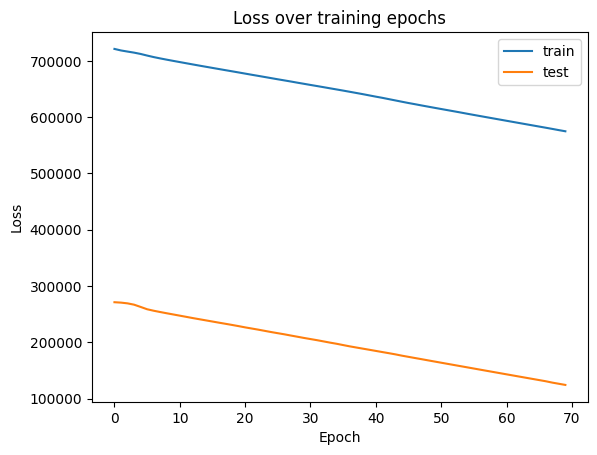

In [78]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [79]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [80]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [81]:
def predict(model, dataset):

  predictions, losses = [], []

  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():

    model = model.eval()

    for seq_true in dataset:

      seq_true = seq_true.to(device)

      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())

      losses.append(loss.item())

  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

/var/folders/p2/j3lbpcl141q66c1kqyxwsc3w0000gn/T/ipykernel_44952/1153265548.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


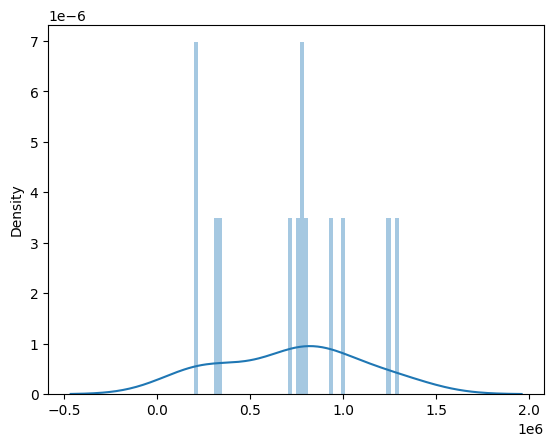

In [82]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [93]:
THRESHOLD = 1500000

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

/var/folders/p2/j3lbpcl141q66c1kqyxwsc3w0000gn/T/ipykernel_44952/3242963548.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);
/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch/venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


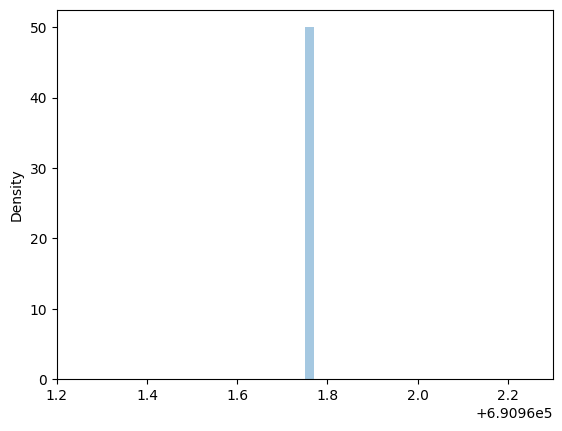

In [94]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [95]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 1/1


### Anomalies
We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [96]:
len(test_anomaly_dataset)

80

In [97]:
len(test_normal_dataset)

1

In [98]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

/var/folders/p2/j3lbpcl141q66c1kqyxwsc3w0000gn/T/ipykernel_44952/2222098121.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);
/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch/venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


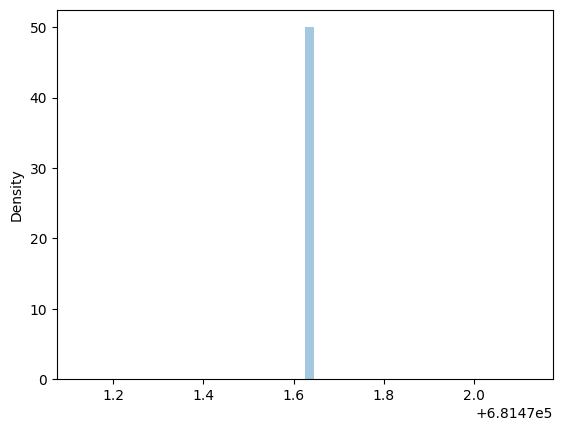

In [99]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [100]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 0/1


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [101]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

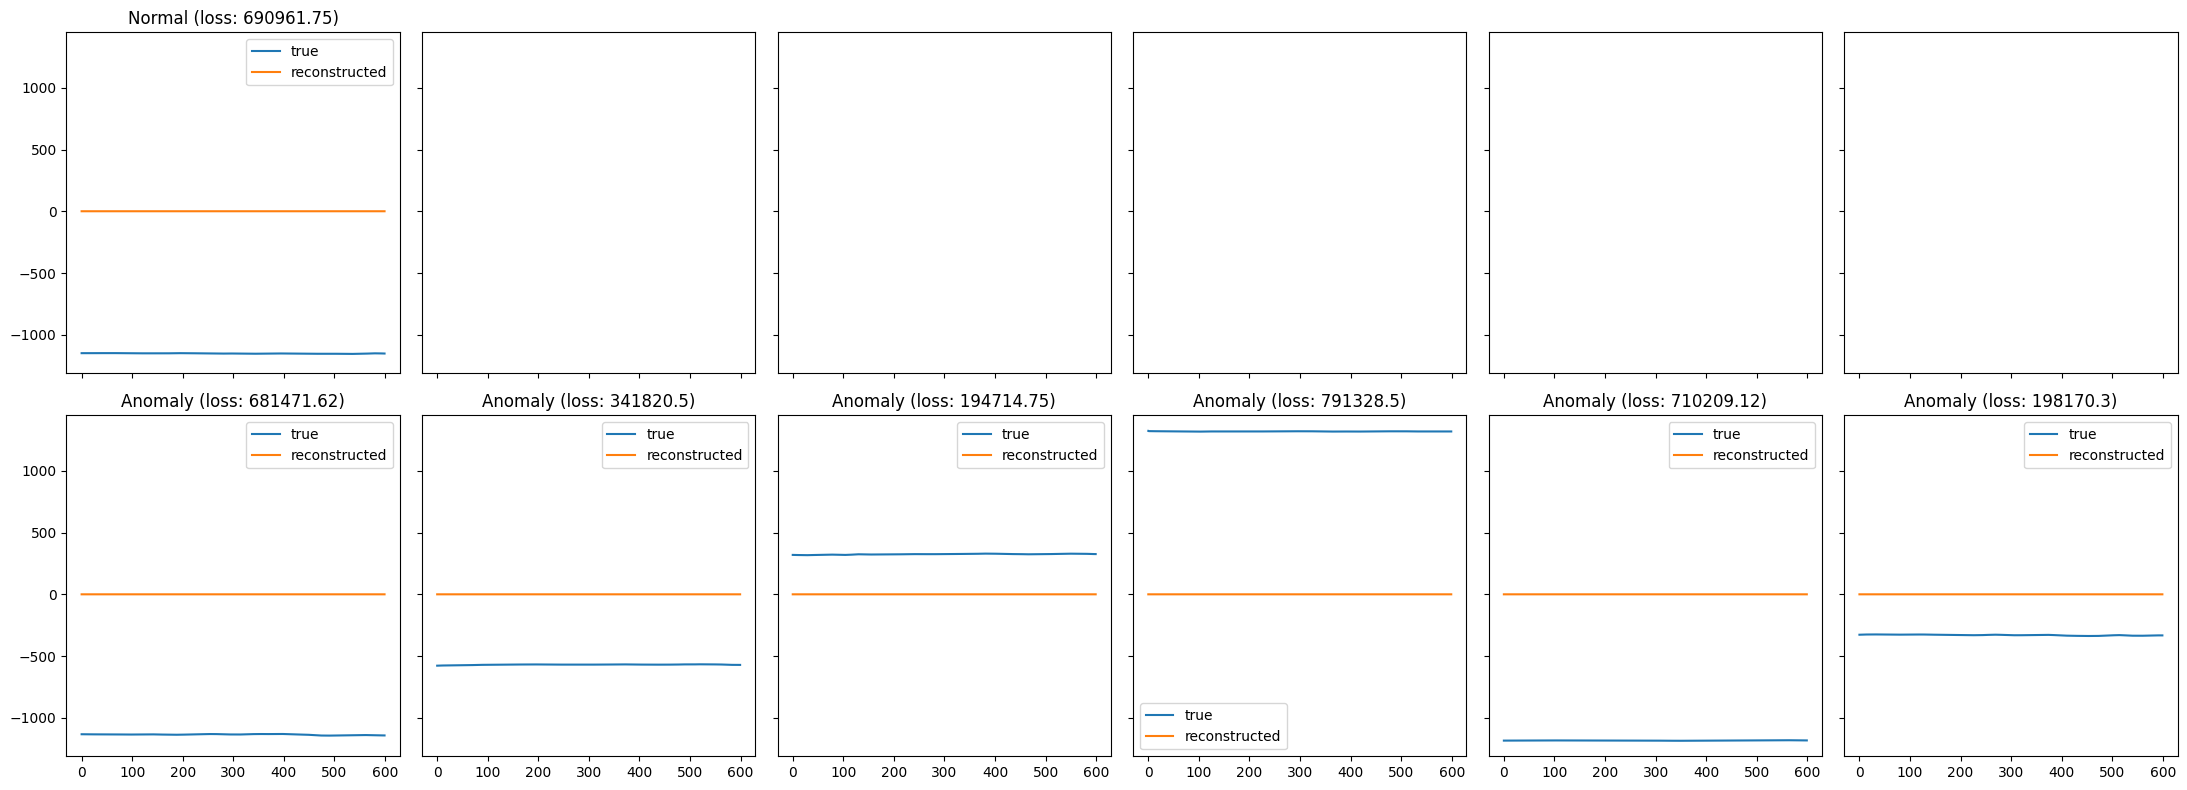

In [102]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)